<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [10]</a>'.</span>

# Plotting Drake Passage Transport in ACCESS-OM3

This notebook uses the initial spinup simulation of ACCESS-OM3.

In [1]:
#The following cell must be in all notebooks!

In [2]:
#parameters

### USER EDIT start
esm_file='/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json'
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.dpi']= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json
Plot folder path:  /g/data/tm70/cyb561/access-om3-paper-figs/


In [3]:
# Parameters
esm_file = "/g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json"
plotfolder = "/g/data/tm70/cyb561/access-om3-paper-1/notebooks/mkfigs_output4/"


In [4]:
import intake
from dask.distributed import Client
import matplotlib.pyplot as plt
import cmocean as cm
import cftime


In [5]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

http://127.0.0.1:8787/status


## Load ACCESS-OM3 data from ESM datastore

In [6]:
#datastore_path = "/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json"

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

In [7]:
umo_2d = datastore.search(variable="umo_2d").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    )
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


## Load ACCESS-OM2 data from ACCESS-NRI Catalog

In [8]:
catalog = intake.cat.access_nri

In [9]:
var = catalog['025deg_jra55_ryf9091_gadi'].search(variable='tx_trans_int_z',frequency="1mon")
var.esmcat.aggregation_control.groupby_attrs = ['frequency']  ## Not sure why I have to do this!!
tx_trans_int_z=var.to_dask(
            xarray_open_kwargs=dict(
            chunks={"time": -1},
            decode_timedelta=True,
            use_cftime=True)
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


## Just to show the latitude I've picked ...

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

ValueError: The input coordinate is not sorted in increasing order along axis 0. This can lead to unexpected results. Consider calling the `sortby` method on the input DataArray. To plot data with categorical axes, consider using the `heatmap` function from the `seaborn` statistical plotting library.

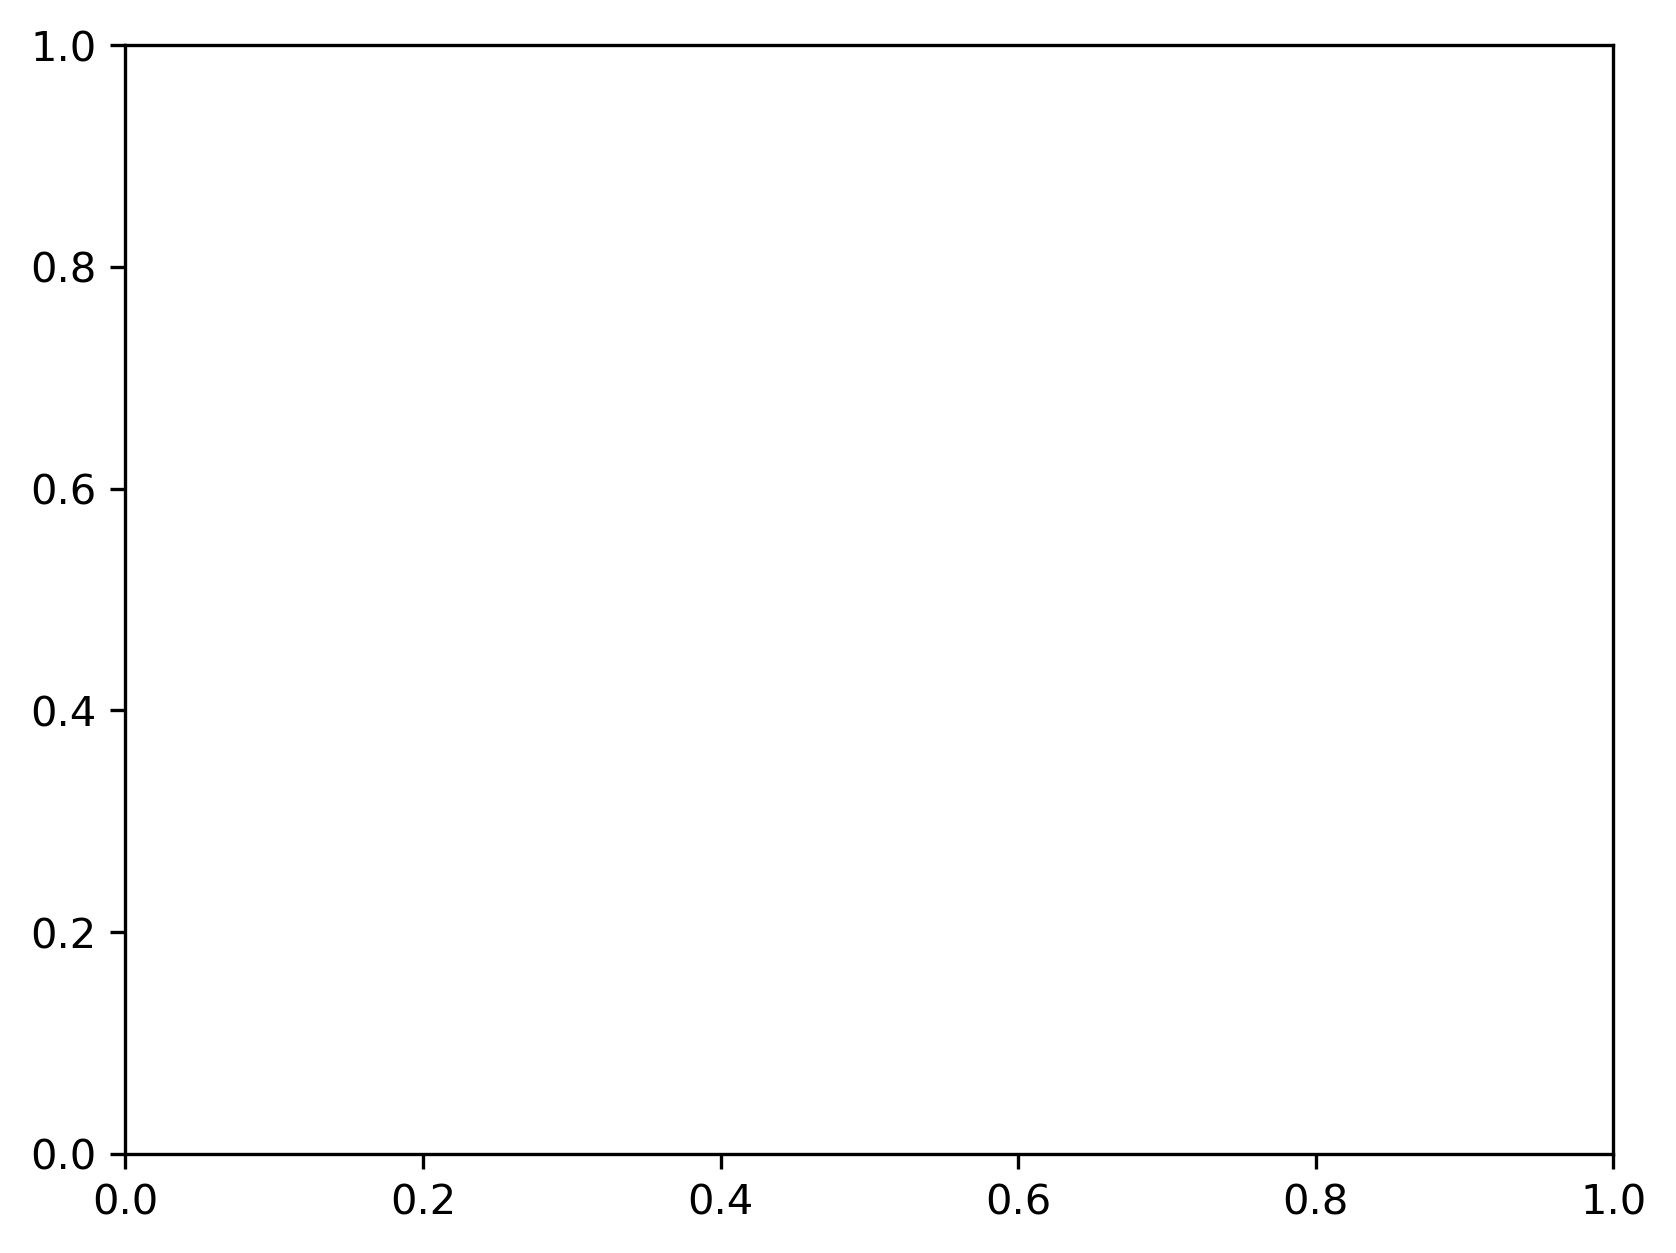

In [10]:
umo_2d["umo_2d"].isel(time=0).plot()
plt.plot([-70,-70],[-71,-54])
plt.xlim([-100,-50])
plt.ylim([-80,-40])

## Timeseries of DP Transport at -70°

In [ ]:
DP_Trans_OM3 = umo_2d["umo_2d"].sel(xq=-70,method='nearest').sel(yh=slice(-71,-54)).sum("yh").load() / 1025 / 1e6

In [ ]:
DP_Trans_OM2 = tx_trans_int_z["tx_trans_int_z"].sel(xu_ocean=-70,method='nearest').sel(yt_ocean=slice(-71,-54)).sum("yt_ocean").sel(time=slice(cftime.datetime(1900, 1, 1,calendar='noleap'), cftime.datetime(1950, 12, 31,calendar='noleap'))).load() / 1036 / 1e6

In [ ]:
plt.figure(figsize=(10, 5)) 

DP_Trans_OM2.rolling(time=12).mean().plot(label='ACCESS-OM2')
DP_Trans_OM3.rolling(time=12).mean().plot(label='ACCESS-OM3')

plt.plot([cftime.datetime(1900, 1, 1), cftime.datetime(1950, 12, 31)], [173, 173],
           'k--', label="Donohue et al. (2016)")

plt.ylabel('Streamfunction (Sv)')
plt.title('Drake Passage Transport')
plt.legend()

In [ ]:
client.close()